<a href="https://colab.research.google.com/github/deosha/pneumonia-detection/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install -q kaggle

In [9]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deoshankar","key":"911f1be2070fcfe044de4f5692e19975"}'}

In [10]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! ls /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
kaggle.json


In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets list

ref                                                              title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
carlmcbrideellis/llm-7-prompt-training-dataset                   LLM: 7 prompt training dataset                     41MB  2023-11-15 07:32:56           1056         90  1.0              
thedrcat/daigt-v2-train-dataset                                  DAIGT V2 Train Dataset                             29MB  2023-11-16 01:38:36            557         74  1.0              
thedrcat/daigt-proper-train-dataset                              DAIGT Proper Train Dataset                        119MB  2023-11-05 14:03:25           1110        115  1.0              
joebeachcapital/30000-spotify-songs                              

In [13]:
! pwd
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

/content
 99% 2.28G/2.29G [00:10<00:00, 237MB/s]
100% 2.29G/2.29G [00:10<00:00, 235MB/s]


In [14]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [15]:
class_names = ['NORMAL', 'PNEUMONIA']
nb_classes = len(class_names)
image_size = (220,220)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dropout, MaxPooling2D, Dense, Conv2D, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
import warnings
warnings.filterwarnings("ignore")

In [17]:
def load_data():

    datasets = ['/content/chest_xray/train',
                '/content/chest_xray/test']
    images = []
    labels = []

    count =0
    for dataset in datasets:

        for folder in os.listdir(dataset):
          if folder in ['NORMAL']: label = 0
          elif folder in ['PNEUMONIA']: label = 1

          for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                try:
                  image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
                except:
                    continue
                images.append(image)
                labels.append(label)
          print()

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [18]:
images, labels = load_data()

100%|██████████| 1341/1341 [00:53<00:00, 25.19it/s]


100%|██████████| 3875/3875 [01:00<00:00, 64.18it/s]


100%|██████████| 234/234 [00:08<00:00, 28.61it/s]


100%|██████████| 390/390 [00:05<00:00, 73.23it/s]


In [19]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.23)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [20]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training instances: {}".format(n_train))
print("Number of validation instances: {}".format(n_val))
print("Number of test instances: {}".format(n_test))

print("Shape of training dataset: {}".format(train_images.shape))
print("Shape of training images labels: {}".format(train_labels.shape))
print("Shape of validation dataset: {}".format(val_images.shape))
print("Shape of validation images labels: {}".format(val_labels.shape))
print("Shape of test dataset: {}".format(test_images.shape))
print("Shape of test images labels: {}".format(test_labels.shape))

Number of training instances: 4496
Number of validation instances: 672
Number of test instances: 672
Shape of training dataset: (4496, 220, 220, 3)
Shape of training images labels: (4496,)
Shape of validation dataset: (672, 220, 220, 3)
Shape of validation images labels: (672,)
Shape of test dataset: (672, 220, 220, 3)
Shape of test images labels: (672,)


In [21]:
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

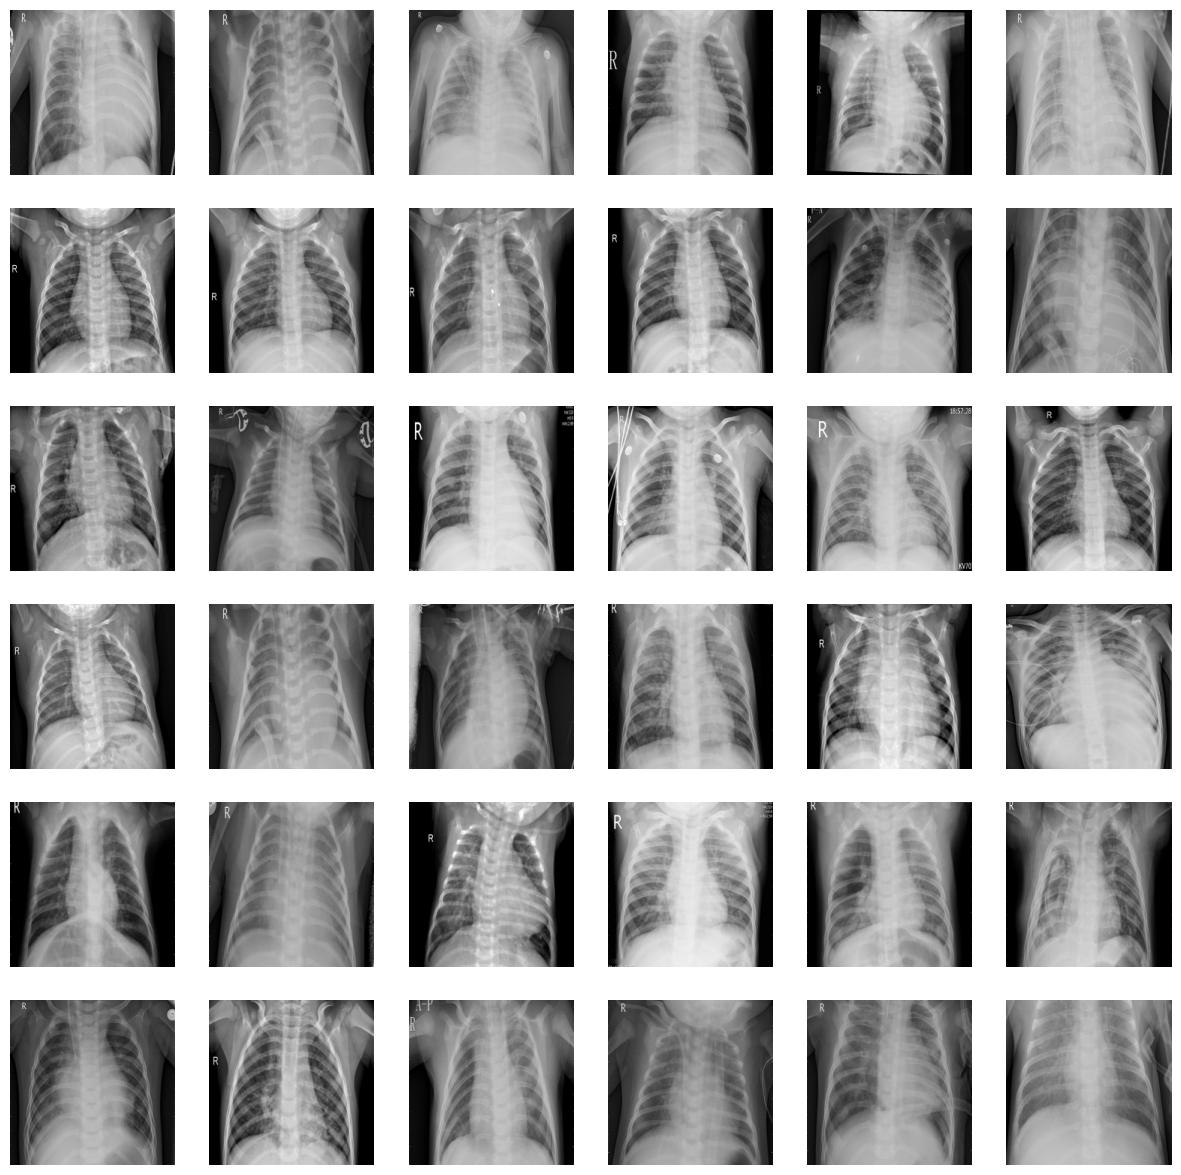

In [22]:
plt.figure(figsize=(15,15))
for n,i in enumerate(list(np.random.randint(0,len(train_images),36))):
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])
    plt.axis("off")

In [23]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

94668760/94668760 [==============================] - 0s 0us/step


In [24]:
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False

model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = "sigmoid"))

In [25]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36410113 (138.89 MB)
Trainable params: 12845313 (49.00 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


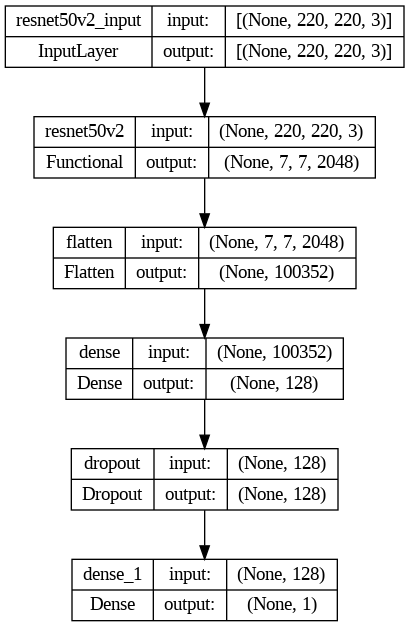

In [27]:
tf.keras.utils.plot_model(
    model, show_layer_names=True, show_shapes=True)

In [28]:
history = model.fit(
    x = train_images,
    y = train_labels,
    batch_size = 16,
    epochs = 10,
    validation_data=(val_images, val_labels)
)

Epoch 1/10
281/281 [==============================] - 242s 846ms/step - loss: 1.0825 - accuracy: 0.9222 - val_loss: 0.1154 - val_accuracy: 0.9598
Epoch 2/10
281/281 [==============================] - 249s 887ms/step - loss: 0.1769 - accuracy: 0.9460 - val_loss: 0.1691 - val_accuracy: 0.9315
Epoch 3/10
281/281 [==============================] - 237s 842ms/step - loss: 0.1592 - accuracy: 0.9417 - val_loss: 0.0908 - val_accuracy: 0.9673
Epoch 4/10
281/281 [==============================] - 238s 846ms/step - loss: 0.1275 - accuracy: 0.9535 - val_loss: 0.0846 - val_accuracy: 0.9717
Epoch 5/10
281/281 [==============================] - 236s 840ms/step - loss: 0.1149 - accuracy: 0.9613 - val_loss: 0.0745 - val_accuracy: 0.9717
Epoch 6/10
281/281 [==============================] - 237s 845ms/step - loss: 0.1018 - accuracy: 0.9660 - val_loss: 0.1166 - val_accuracy: 0.9658
Epoch 7/10
281/281 [==============================] - 236s 839ms/step - loss: 0.0957 - accuracy: 0.9635 - val_loss: 0.1015 -

In [29]:
scores = model.evaluate(test_images, test_labels)
print("Accuracy on test data: %.2f%%" % (scores[1]*100))


21/21 [==============================] - 28s 1s/step - loss: 0.1717 - accuracy: 0.9658
Accuracy on test data: 96.58%


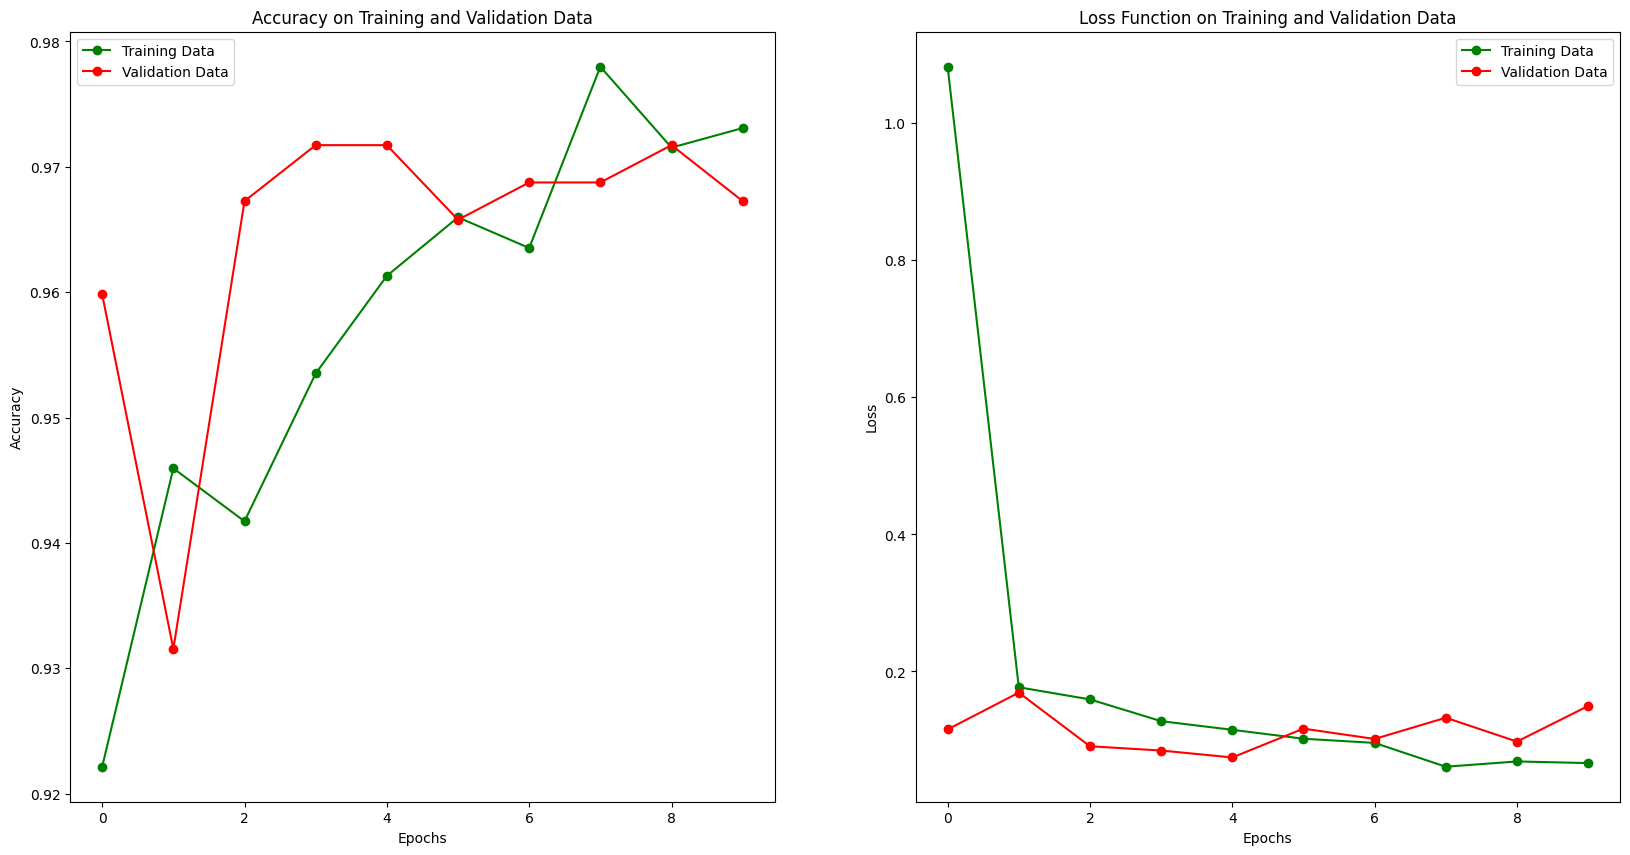

In [30]:
history = history
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)
ax[0].plot(epochs, train_acc, 'go-', label = 'Training Data')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Data')
ax[0].set_title('Accuracy on Training and Validation Data')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label = 'Training Data')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Data')
ax[1].set_title('Loss Function on Training and Validation Data')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


Actual Class: PNEUMONIA
21/21 [==============================] - 27s 1s/step
Predicted Class: PNEUMONIA 



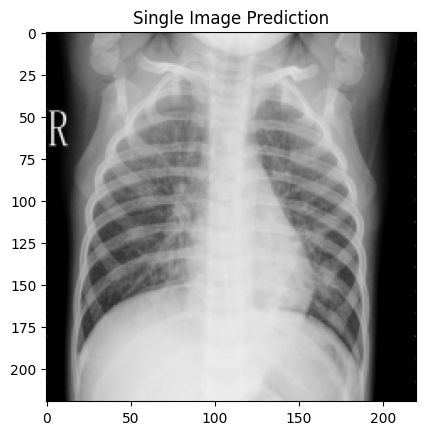

In [34]:
first_image = test_images[0]
first_label = test_labels[0]

plt.title("Single Image Prediction")
plt.imshow(first_image)
print("Actual Class:", class_names[first_label])

predictions = model.predict(test_images)
print("Predicted Class:", class_names[int(np.ceil(predictions[0]))], '\n')
